In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
data1 = pd.read_csv('RU_Electricity_Market_PZ_dayahead_price_volume.csv')
data2 = pd.read_csv('RU_Electricity_Market_UES_dayahead_price.csv')
data3 = pd.read_csv('RU_Electricity_Market_UES_intraday_price.csv')

In [3]:
data1.head()

,timestep,consumption_eur,consumption_sib,price_eur,price_sib
0,2006-09-01 00:00,62341.0,17916.0,275.22,0.0
1,2006-09-01 01:00,60625.0,17467.0,0.00,0.0
2,2006-09-01 02:00,59685.0,17161.0,0.00,0.0
3,2006-09-01 03:00,59500.0,17061.0,0.00,0.0
4,2006-09-01 04:00,60617.0,17074.0,0.00,0.0


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45816 entries, 0 to 45815
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestep         45816 non-null  object 
 1   consumption_eur  45816 non-null  float64
 2   consumption_sib  45816 non-null  float64
 3   price_eur        45816 non-null  float64
 4   price_sib        45816 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.7+ MB


In [5]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23952 entries, 0 to 23951
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestep          23952 non-null  object 
 1   UES_Northwest     23952 non-null  float64
 2   UES_Siberia       23952 non-null  float64
 3   UES_Middle_Volga  23952 non-null  float64
 4   UES_Urals         23952 non-null  float64
 5   UES_Center        23952 non-null  float64
 6   UES_South         23952 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.3+ MB


In [6]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24072 entries, 0 to 24071
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   timestep       24072 non-null  object
 1   UES_Northwest  24072 non-null  int64 
 2   UES_Siberia    24072 non-null  int64 
 3   UES_Center     24072 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 752.4+ KB


Изменим формат исходных данных для выделения дополнительных признаков.

In [7]:
data1['datetime'] = pd.to_datetime(data1['timestep'])
data1.drop(['timestep'], axis=1, inplace=True)
data1.set_index(['datetime'], drop=True, inplace=True)
data1.head()

,consumption_eur,consumption_sib,price_eur,price_sib
datetime,,,,
2006-09-01 00:00:00,62341.0,17916.0,275.22,0.0
2006-09-01 01:00:00,60625.0,17467.0,0.00,0.0
2006-09-01 02:00:00,59685.0,17161.0,0.00,0.0
2006-09-01 03:00:00,59500.0,17061.0,0.00,0.0
2006-09-01 04:00:00,60617.0,17074.0,0.00,0.0


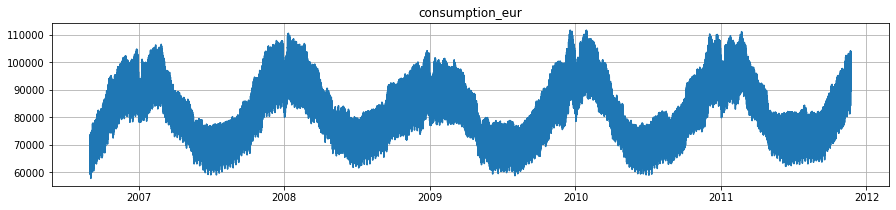

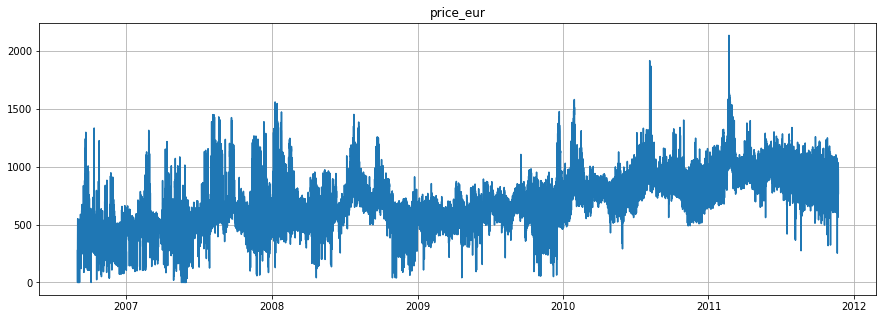

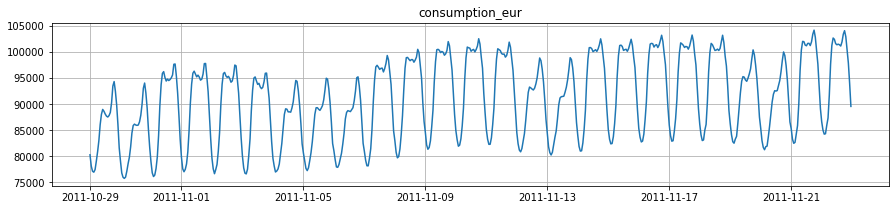

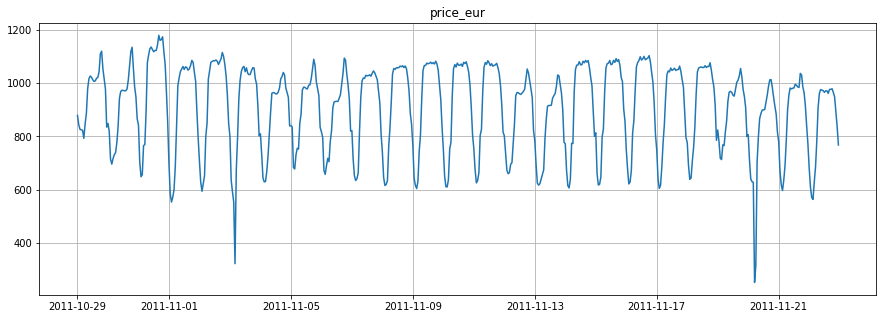

In [8]:
# Посмотрим на данные
f=plt.figure(figsize=(15,3))
plt.plot(data1['consumption_eur'])
plt.grid()
plt.title('consumption_eur')
plt.show()
f=plt.figure(figsize=(15,5))
plt.plot(data1['price_eur'])
plt.grid()
plt.title('price_eur')
plt.show()
f.savefig('price_eur.png', dpi = 200)
f=plt.figure(figsize=(15,3))
plt.plot(data1['consumption_eur'][-600:])
plt.grid()
plt.title('consumption_eur')
plt.show()
f=plt.figure(figsize=(15,5))
plt.plot(data1['price_eur'][-600:])
plt.grid()
plt.title('price_eur')
plt.show()
f.savefig('price_eur_week.png', dpi = 200)

Можно заметить в обоих временных рядах наличие тренда и аномалий, отсутствие сезонности и наличие дневной цикличности.

One-hot encoding календарных признаков

In [9]:
data1["hour"] = data1.index.hour
data1["weekday"] = data1.index.weekday
data1['is_weekend'] = data1.weekday.isin([5,6])*1
data1.head()

,consumption_eur,consumption_sib,price_eur,price_sib,hour,weekday,is_weekend
datetime,,,,,,,
2006-09-01 00:00:00,62341.0,17916.0,275.22,0.0,0,4,0
2006-09-01 01:00:00,60625.0,17467.0,0.00,0.0,1,4,0
2006-09-01 02:00:00,59685.0,17161.0,0.00,0.0,2,4,0
2006-09-01 03:00:00,59500.0,17061.0,0.00,0.0,3,4,0
2006-09-01 04:00:00,60617.0,17074.0,0.00,0.0,4,4,0


Удалим лишние данные и проанализируем получившийся временной ряд.

In [10]:
data1.drop(['consumption_eur', 'consumption_sib', 'price_sib'], axis = 1, inplace = True)
data1[1000:1010]

,price_eur,hour,weekday,is_weekend
datetime,,,,
2006-10-12 16:00:00,547.42,16,3,0
2006-10-12 17:00:00,559.49,17,3,0
2006-10-12 18:00:00,584.13,18,3,0
2006-10-12 19:00:00,728.69,19,3,0
2006-10-12 20:00:00,1334.15,20,3,0
2006-10-12 21:00:00,563.78,21,3,0
2006-10-12 22:00:00,532.68,22,3,0
2006-10-12 23:00:00,432.35,23,3,0
2006-10-13 00:00:00,384.63,0,4,0


In [11]:
time_series = data1.drop(['hour', 'weekday', 'is_weekend'], axis = 1)

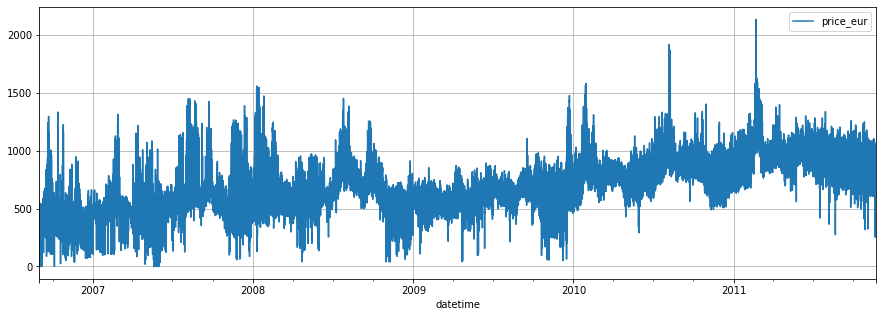

In [12]:
time_series.plot(figsize = (15,5), grid = True);

In [13]:
def plotMovingAverage(series, n, plot_bounds=False):
    rolling_mean = series.rolling(window=n).mean()  
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title(f"Moving average\n window size = {n}")
    plt.plot(rolling_mean, label="Rolling mean trend")
    plt.legend(loc="upper left")
    plt.grid()
    fig.savefig('Moving average', dpi = 200)

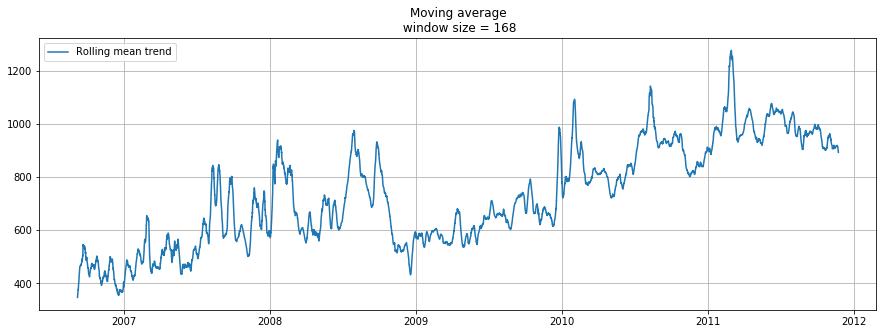

In [14]:
#plotMovingAverage(time_series, 24)
plotMovingAverage(time_series, 24 * 7)

Ряд не являеться стационарным, т.к. имеет ярко выраженный тренд.

In [15]:
print(f'V = {round((time_series.to_numpy().std() / time_series.to_numpy().mean()), 3)}')

V = 0.328


Ряд близок к однородному, о чём свидетельствует коэффициент вариации.

In [16]:
# RMSE = []
# for i in range(1, 50):
#     gen = samples(data1, train_length = 24 * i, test_length = 24 * 3,  number_samples = 100);
#     rmse = []
#     mae = []
#     for j in range(50):
#         X_train, y_train, X_test, y_test = next(gen)

#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         dtest = xgb.DMatrix(X_test)
#         cv = xgb.cv(
#             params,
#             dtrain,
#             metrics=("rmse"),
#             verbose_eval=False,
#             show_stdv=False,
#             num_boost_round=50
#         )
#         bst = xgb.train(params, dtrain, num_boost_round=cv["test-rmse-mean"].argmin())
#         prediction_test = bst.predict(dtest)
#         rmse.append(np.sqrt(mean_squared_error(prediction_test, y_test)))
#         mae.append(mean_absolute_error(prediction_test, y_test))
#     RMSE.append(np.asarray(rmse).mean())

In [17]:
# plt.figure(figsize=(8, 4))
# plt.plot(range(1, 50), RMSE)
# plt.xlabel('day')
# plt.ylabel('rmse')
# plt.grid();

In [19]:
def samples(data, train_length = 24 * 30, test_length = 24 * 7, number_samples = 100):
    X = data.drop('price_eur', axis = 1)
    y = data['price_eur']
    for i in range(number_samples):
        start_index = random.randint(0, len(data) - test_length - train_length - 2)
        a = start_index + train_length
        b = start_index + test_length + train_length
        X_train = data.iloc[start_index : a].drop(["price_eur"], axis=1)
        y_train = data.iloc[start_index : a]["price_eur"]
        X_test = data.iloc[a : b].drop(["price_eur"], axis=1)
        y_test = data.iloc[a : b]["price_eur"]
        yield X_train, y_train, X_test, y_test

In [20]:
gen = samples(data1)
X_train, y_train, X_test, y_test = next(gen)
dtrain = xgb.DMatrix (X_train, label = y_train) 
dtest = xgb.DMatrix (X_test, label = y_test)

params = {
    'max_depth': 6, 
    'min_child_weight' : 1, # создание более сложных деревьев за счёт добавления новых узлов  [0, ∞]
    'eta' : 0.3, # контролирет скорость обучения, за счёт уменьшения весов [0,1]
    'subsample' : 1, # кол-во даных используемых на этапе обучения (0,1]
    'colsample_bytree' : 1, # кол-во признаков, используемых для обучения (0, 1]  
    'objective' : 'reg:squarederror', 
    'eval_metric' : "rmse"
}

In [21]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,8)
    for min_child_weight in range(0,8)
]

In [22]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print(f"RMSE {round(min_rmse,3)} for {boost_rounds} rounds")
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print (f"Лучшие параметры: {best_params [0]}, {best_params [1]}, RMSE: {round(min_rmse,3)}")
params['max_depth'] = best_params [0]
params['min_child_weight'] = best_params [1]

RMSE inf for 74 rounds
RMSE 75.376 for 74 rounds
RMSE 75.376 for 74 rounds
RMSE 75.376 for 74 rounds
RMSE 75.376 for 74 rounds
RMSE 75.376 for 74 rounds
RMSE 75.376 for 74 rounds
RMSE 75.376 for 74 rounds
RMSE 75.376 for 41 rounds
RMSE 70.187 for 41 rounds
RMSE 70.187 for 41 rounds
RMSE 70.187 for 42 rounds
RMSE 70.172 for 41 rounds
RMSE 70.172 for 53 rounds
RMSE 70.081 for 41 rounds
RMSE 70.081 for 53 rounds
RMSE 70.057 for 15 rounds
RMSE 69.51 for 15 rounds
RMSE 69.51 for 15 rounds
RMSE 69.51 for 13 rounds
RMSE 69.51 for 13 rounds
RMSE 69.51 for 13 rounds
RMSE 69.51 for 13 rounds
RMSE 69.51 for 15 rounds
RMSE 69.51 for 11 rounds
RMSE 69.51 for 11 rounds
RMSE 69.51 for 11 rounds
RMSE 69.51 for 11 rounds
RMSE 69.51 for 11 rounds
RMSE 69.51 for 11 rounds
RMSE 69.51 for 11 rounds
RMSE 69.51 for 12 rounds
RMSE 69.51 for 10 rounds
RMSE 69.51 for 10 rounds
RMSE 69.51 for 10 rounds
RMSE 69.51 for 10 rounds
RMSE 69.51 for 10 rounds
RMSE 69.51 for 11 rounds
RMSE 69.51 for 10 rounds
RMSE 69.51 

In [23]:
params

{'max_depth': 3,
 'min_child_weight': 0,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

Найдём оптимальное число раундов, с подобранными оптимальными параметрами

In [24]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round= 1000,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:388.75263
[1]	Test-rmse:296.14621
[2]	Test-rmse:231.92607
[3]	Test-rmse:187.55400
[4]	Test-rmse:156.43338
[5]	Test-rmse:134.83354
[6]	Test-rmse:120.69343
[7]	Test-rmse:111.06906
[8]	Test-rmse:104.28981
[9]	Test-rmse:99.26139
[10]	Test-rmse:95.82695
[11]	Test-rmse:94.29753
[12]	Test-rmse:92.57496
[13]	Test-rmse:91.33054
[14]	Test-rmse:90.48865
[15]	Test-rmse:89.91937
[16]	Test-rmse:89.79874
[17]	Test-rmse:89.48446
[18]	Test-rmse:89.08932
[19]	Test-rmse:89.15660
[20]	Test-rmse:89.19760
[21]	Test-rmse:89.06821
[22]	Test-rmse:88.96873
[23]	Test-rmse:88.86005
[24]	Test-rmse:88.98644
[25]	Test-rmse:88.95101
[26]	Test-rmse:89.06010
[27]	Test-rmse:89.10828
[28]	Test-rmse:89.06564
[29]	Test-rmse:89.09894
[30]	Test-rmse:88.99585
[31]	Test-rmse:88.95837
[32]	Test-rmse:88.92760
[33]	Test-rmse:88.90833


Итоговая модель

In [25]:
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round= model.best_iteration + 1
)

In [26]:
prediction = best_model.predict(dtest)
rmse = np.sqrt(mean_squared_error(prediction, y_test))
mae = mean_absolute_error(prediction, y_test)
print(f'RMSE: {round(rmse,1)}\nMAE: {round(mae,1)}')

RMSE: 88.9
MAE: 74.5


RMSE: 88.9
MAE: 74.5


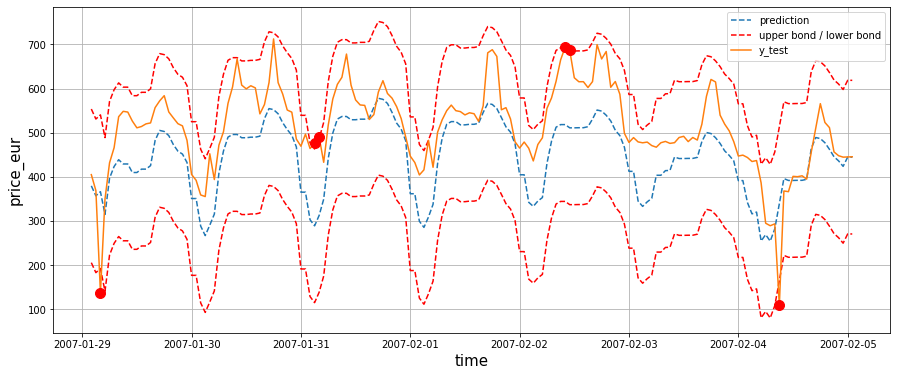

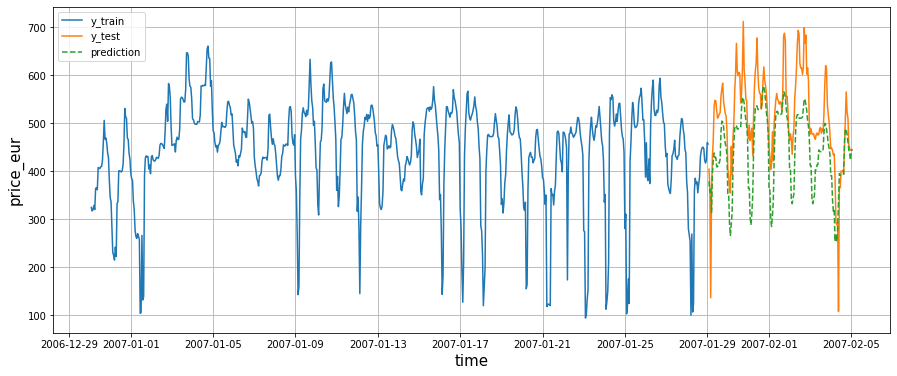

In [27]:
prediction = best_model.predict(dtest)
lower = prediction - 1.96 * rmse
upper = prediction + 1.96 * rmse

Anomalies_below = np.array([np.NaN] * len(y_test))
Anomalies_below[y_test < lower] = y_test[y_test < lower]

Anomalies_above = np.array([np.NaN] * len(y_test))
Anomalies_above[y_test > upper] = y_test[y_test > upper]

new_data = pd.DataFrame(y_test)
new_data['prediction'] = prediction
new_data['lower'] = lower
new_data['upper'] = upper
new_data['Anomalies_below'] = Anomalies_below
new_data['Anomalies_above'] = Anomalies_above
plt.figure(figsize=(15, 6))
plt.plot(new_data['prediction'], '--', label="prediction")
plt.plot(new_data['lower'], "r--", label="upper bond / lower bond")
plt.plot(new_data['upper'], "r--")
plt.plot(y_test, label="y_test")
plt.plot(new_data['Anomalies_below'], "ro", markersize=10)
plt.plot(new_data['Anomalies_above'], "ro", markersize=10)
plt.legend(loc="best")
plt.xlabel('time', fontsize = 15)
plt.ylabel('price_eur', fontsize = 15)
plt.axis("tight")
plt.grid(True)
plt.legend();
rmse = np.sqrt(mean_squared_error(prediction, y_test))
mae = mean_absolute_error(prediction, y_test)
print(f'RMSE: {round(rmse,1)}\nMAE: {round(mae,1)}')
plt.savefig('Result1.png', dpi = 200)
plt.figure(figsize=(15, 6))
#plt.ylim(0,1500)
plt.plot(y_train, label="y_train")
plt.plot(y_test, label="y_test")
plt.plot(new_data['prediction'], '--', label="prediction")
plt.xlabel('time', fontsize = 15)
plt.ylabel('price_eur', fontsize = 15)
plt.legend(loc="best")
plt.grid()
plt.savefig('Result2.png', dpi = 200)

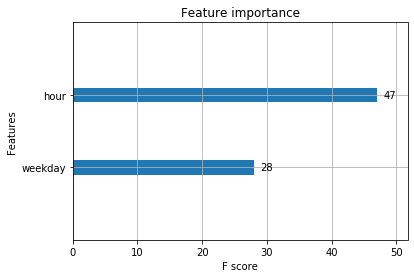

In [25]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
#gen = samples(data1, train_length = 24 * 10, test_length = 24 * 2, number_samples = 100)
MAEmean = []
for i in range(50):
    X_train, y_train, X_test, y_test = next(gen)
    dtrain = xgb.DMatrix (X_train, label = y_train) 
    dtest = xgb.DMatrix (X_test, label = y_test)

    params = {
        'max_depth': 6, 
        'min_child_weight' : 1, # создание более сложных деревьев за счёт добавления новых узлов  [0, ∞]
        'eta' : 0.3, # контролирет скорость обучения, за счёт уменьшения весов [0,1]
        'subsample' : 1, # кол-во даных используемых на этапе обучения (0,1]
        'colsample_bytree' : 1, # кол-во признаков, используемых для обучения (0, 1]  
        'objective' : 'reg:squarederror', 
        'eval_metric' : "rmse"}
    min_rmse = float("Inf")
    best_params = None
    for max_depth, min_child_weight in gridsearch_params:
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=1000,
            nfold=5,
            metrics={'rmse'},
            early_stopping_rounds=10)
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].argmin()
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_params = (max_depth,min_child_weight)
    print (f"Лучшие параметры: {best_params [0]}, {best_params [1]}")
    params['max_depth'] = best_params [0]
    params['min_child_weight'] = best_params [1]
    best_model = xgb.XGBRegressor(max_depth = params['max_depth'],
                          min_child_weight = params['min_child_weight'],
                          eta = params['eta'],
                          subsample = params['subsample'],
                          colsample_bytree = params['colsample_bytree'],
                          objective = params['objective'],
                          eval_metric = params['eval_metric']).fit(X_train, y_train)
    prediction = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(prediction, y_test))
    mae = mean_absolute_error(prediction, y_test)
    MAEmean.append(mae)
# lower = prediction - 1.96 * rmse
# upper = prediction + 1.96 * rmse

# Anomalies_below = np.array([np.NaN] * len(y_test))
# Anomalies_below[y_test < lower] = y_test[y_test < lower]

# Anomalies_above = np.array([np.NaN] * len(y_test))
# Anomalies_above[y_test > upper] = y_test[y_test > upper]

# new_data = pd.DataFrame(y_test)
# new_data['prediction'] = prediction
# new_data['lower'] = lower
# new_data['upper'] = upper
# new_data['Anomalies_below'] = Anomalies_below
# new_data['Anomalies_above'] = Anomalies_above
# plt.figure(figsize=(15, 6))
# plt.plot(new_data['prediction'], '--', label="prediction")
# plt.plot(new_data['lower'], "r--", label="upper bond / lower bond")
# plt.plot(new_data['upper'], "r--")
# plt.plot(y_test, label="y_test")
# plt.plot(new_data['Anomalies_below'], "ro", markersize=10)
# plt.plot(new_data['Anomalies_above'], "ro", markersize=10)
# plt.legend(loc="best")
# plt.xlabel('time', fontsize = 15)
# plt.ylabel('price_eur', fontsize = 15)
# plt.axis("tight")
# plt.grid(True)
# plt.legend();
# print(f'RMSE: {round(rmse,1)}\nMAE: {round(mae,1)}')
# plt.savefig('Result1.png', dpi = 200)
# plt.figure(figsize=(15, 6))
# #plt.ylim(0,1500)
# plt.plot(y_train, label="y_train")
# plt.plot(y_test, label="y_test")
# plt.plot(new_data['prediction'], '--', label="prediction")
# plt.xlabel('time', fontsize = 15)
# plt.ylabel('price_eur', fontsize = 15)
# plt.legend(loc="best")
# plt.grid()
# plt.savefig('Result2.png', dpi = 200)

In [32]:
print(f'mean MAE: {np.mean(MAEmean):1.1f}')

mean MAE: 85.8
